In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
import os
from os.path import isfile
from pandas import DataFrame

In [48]:
import pandas as pd

optfileList = ['../data/CRex/RHRS/CRex_DataSet_21743.csv',
               '../data/CRex/RHRS/CRex_DataSet_21744.csv',
               '../data/CRex/RHRS/CRex_DataSet_21748.csv',
               '../data/CRex/RHRS/CRex_DataSet_21749.csv',
               '../data/CRex/RHRS/CRex_DataSet_21752.csv',
               '../data/CRex/RHRS/CRex_DataSet_21753.csv',
               '../data/CRex/RHRS/CRex_DataSet_21754.csv',
               '../data/CRex/RHRS/CRex_DataSet_21755.csv',
               '../data/CRex/RHRS/CRex_DataSet_21756.csv',
               '../data/CRex/RHRS/CRex_DataSet_21757.csv',
               '../data/CRex/RHRS/CRex_DataSet_21768.csv',
               '../data/CRex/RHRS/CRex_DataSet_21769.csv',
               '../data/CRex/RHRS/CRex_DataSet_21770.csv',
               '../data/CRex/RHRS/CRex_DataSet_21771.csv',
               '../data/CRex/RHRS/CRex_DataSet_21772.csv',
               '../data/CRex/RHRS/CRex_DataSet_21781.csv',
               '../data/CRex/RHRS/CRex_DataSet_21782.csv',
               '../data/CRex/RHRS/CRex_DataSet_21783.csv',
               '../data/CRex/RHRS/CRex_DataSet_21784.csv',
               '../data/CRex/RHRS/CRex_DataSet_21785.csv',
               ]

# load all the dataset and start the training process
li = []
for file in optfileList:
    if isfile(file):
        df = pd.read_csv(file,index_col=None,header=0)
        li.append(df)
dataInitial = pd.concat(li,axis=0,ignore_index=True)
data = pd.concat(li,axis=0,ignore_index=True)

In [8]:
selected_feature = ['focal_x','focal_y','focal_th','focal_ph']
targetTheta = ['targCalTh']
targetPhi = ['targCalPh']
data=data[selected_feature + targetTheta + targetPhi]

data

,focal_x,focal_y,focal_th,focal_ph,targCalTh,targCalPh
0,-0.301587,0.016011,0.012192,0.000739,-0.029615,-0.006545
1,-0.037429,-0.007679,0.001400,0.011046,-0.009243,0.008405
2,-0.283216,0.012550,0.004096,-0.000475,-0.016034,-0.006545
3,-0.249758,0.006722,-0.003607,0.006061,-0.002452,-0.000295
4,-0.163223,0.010093,-0.018091,0.009351,0.024711,-0.000295
...,...,...,...,...,...,...
384911,-0.174756,0.025478,-0.008025,-0.021762,0.005959,-0.022172
384912,0.002110,0.028486,-0.008300,-0.016913,0.005959,-0.022172
384913,-0.139748,0.026431,-0.008081,-0.021064,0.005959,-0.022172
384914,-0.211684,0.026189,-0.006892,-0.020195,0.005959,-0.022172


In [9]:
from SpectroCalib.feature_engineer._preprocess import PolynomialFeatureTransformer
from sklearn.pipeline import Pipeline

In [10]:
fullpipeline = Pipeline([('poly',PolynomialFeatureTransformer(columns = selected_feature))])

transformed = fullpipeline.fit_transform(data)


trans_Theta = transformed[targetTheta]
trans_Phi   = transformed[targetPhi]
trans_X = transformed.drop(targetTheta + targetPhi,axis=1)

## feature selection

In [11]:
#TODO need to move a seperate class

from sklearn.feature_selection import  SelectKBest, f_regression, mutual_info_regression

transformed_theta_feature = SelectKBest(f_regression,k=30).fit(trans_X,trans_Theta)
transformed_phi_feature   = SelectKBest(f_regression,k=30).fit(trans_X,trans_Phi)

theta_index = transformed_theta_feature.get_support()
phi_index = transformed_phi_feature.get_support()

X_train_theta_columns = trans_X.columns[theta_index]
X_train_phi_columns = trans_X.columns[phi_index]


theta_data = trans_X[X_train_theta_columns]
phi_data = trans_X[X_train_phi_columns]

/home/newdriver/Work/research/Calib/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/newdriver/Work/research/Calib/venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/newdriver/Work/research/Calib/venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/newdriver/Work/research/Calib/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **

### AUTO ML implication

Before move forward, let test it with ```auto-sklearn```


#### train test split

In [12]:
import sklearn
X_train_theta, X_test_theta, y_train_theta, y_test_theta = \
            sklearn.model_selection.train_test_split(theta_data, trans_Theta, random_state=1)


X_train_phi, X_test_phi, y_train_phi, y_test_phi = \
            sklearn.model_selection.train_test_split(phi_data, trans_Phi, random_state=1)

#### Step 1.  **train $\theta$**


In [13]:
import autosklearn.regression
import sklearn.model_selection
import sklearn.metrics
import os

automl_theta = autosklearn.regression.AutoSklearnRegressor(n_jobs=os.cpu_count(),tmp_folder='./tmp/autosklearn_regression_example_tmp_theta')

automl_theta.fit(X=X_train_theta,y=y_train_theta,X_test=X_test_theta,y_test=y_test_theta)


[WARNING] [2021-10-01 14:13:04,640:Client-AutoML(1):34d35611-22e3-11ec-9afd-b37f06f402a9] Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (3599.536934)
[WARNING] [2021-10-01 14:13:04,640:Client-AutoML(1):34d35611-22e3-11ec-9afd-b37f06f402a9] Capping the per_run_time_limit to 1799.0 to have time for a least 2 models in each process.


AutoSklearnRegressor(n_jobs=24, per_run_time_limit=8640,
                     tmp_folder='./tmp/autosklearn_regression_example_tmp_theta')

#### Step 2.  **train $\phi$**

In [15]:
automl_phi = autosklearn.regression.AutoSklearnRegressor(n_jobs=os.cpu_count(),tmp_folder='./tmp/autosklearn_regression_example_tmp_phi')

automl_phi.fit(X=X_train_phi,y=y_train_phi,X_test=X_test_phi,y_test=y_test_phi)

[WARNING] [2021-10-01 15:13:07,245:Client-AutoML(1):9a643d26-22eb-11ec-9afd-b37f06f402a9] Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (3599.555564)
[WARNING] [2021-10-01 15:13:07,245:Client-AutoML(1):9a643d26-22eb-11ec-9afd-b37f06f402a9] Capping the per_run_time_limit to 1799.0 to have time for a least 2 models in each process.


AutoSklearnRegressor(n_jobs=24, per_run_time_limit=8640,
                     tmp_folder='./tmp/autosklearn_regression_example_tmp_phi')

## test on the dataset

* load the dataset
* select the feature
* select sieve holes
* take average of the mean and std


In [40]:
predicted_theta = automl_theta.predict(trans_X[X_train_theta_columns],n_jobs=os.cpu_count())
predicted_phi   = automl_phi.predict(trans_X[X_train_phi_columns],n_jobs=os.cpu_count())

In [49]:
fulldata = dataInitial.copy()

fulldata['predicted_theta'] = predicted_theta
fulldata['predicted_phi']  = predicted_phi

fulldata


,evtID,runID,CutID,SieveRowID,SieveColID,bpmX,bpmY,focal_x,focal_y,focal_th,focal_ph,targCalTh,targCalPh,predicted_theta,predicted_phi
0,0,21743,253,1,8,0.000290,-0.001503,-0.301587,0.016011,0.012192,0.000739,-0.029615,-0.006545,-0.028243,-0.006681
1,1,21743,226,2,4,0.000290,-0.001503,-0.037429,-0.007679,0.001400,0.011046,-0.009243,0.008405,-0.009033,0.008467
2,2,21743,254,2,8,0.000290,-0.001503,-0.283216,0.012550,0.004096,-0.000475,-0.016034,-0.006545,-0.014607,-0.006306
3,3,21743,241,3,6,0.000290,-0.001503,-0.249758,0.006722,-0.003607,0.006061,-0.002452,-0.000295,-0.000464,-0.000317
4,4,21743,243,5,6,0.000290,-0.001503,-0.163223,0.010093,-0.018091,0.009351,0.024711,-0.000295,0.025038,-0.000633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384911,22647,21785,185,3,12,0.000293,-0.000510,-0.174756,0.025478,-0.008025,-0.021762,0.005959,-0.022172,0.005528,-0.022044
384912,22657,21785,185,3,12,0.000293,-0.000510,0.002110,0.028486,-0.008300,-0.016913,0.005959,-0.022172,0.006406,-0.022164
384913,22669,21785,185,3,12,0.000293,-0.000510,-0.139748,0.026431,-0.008081,-0.021064,0.005959,-0.022172,0.005781,-0.022086
384914,22670,21785,185,3,12,0.000293,-0.000510,-0.211684,0.026189,-0.006892,-0.020195,0.005959,-0.022172,0.005060,-0.022004


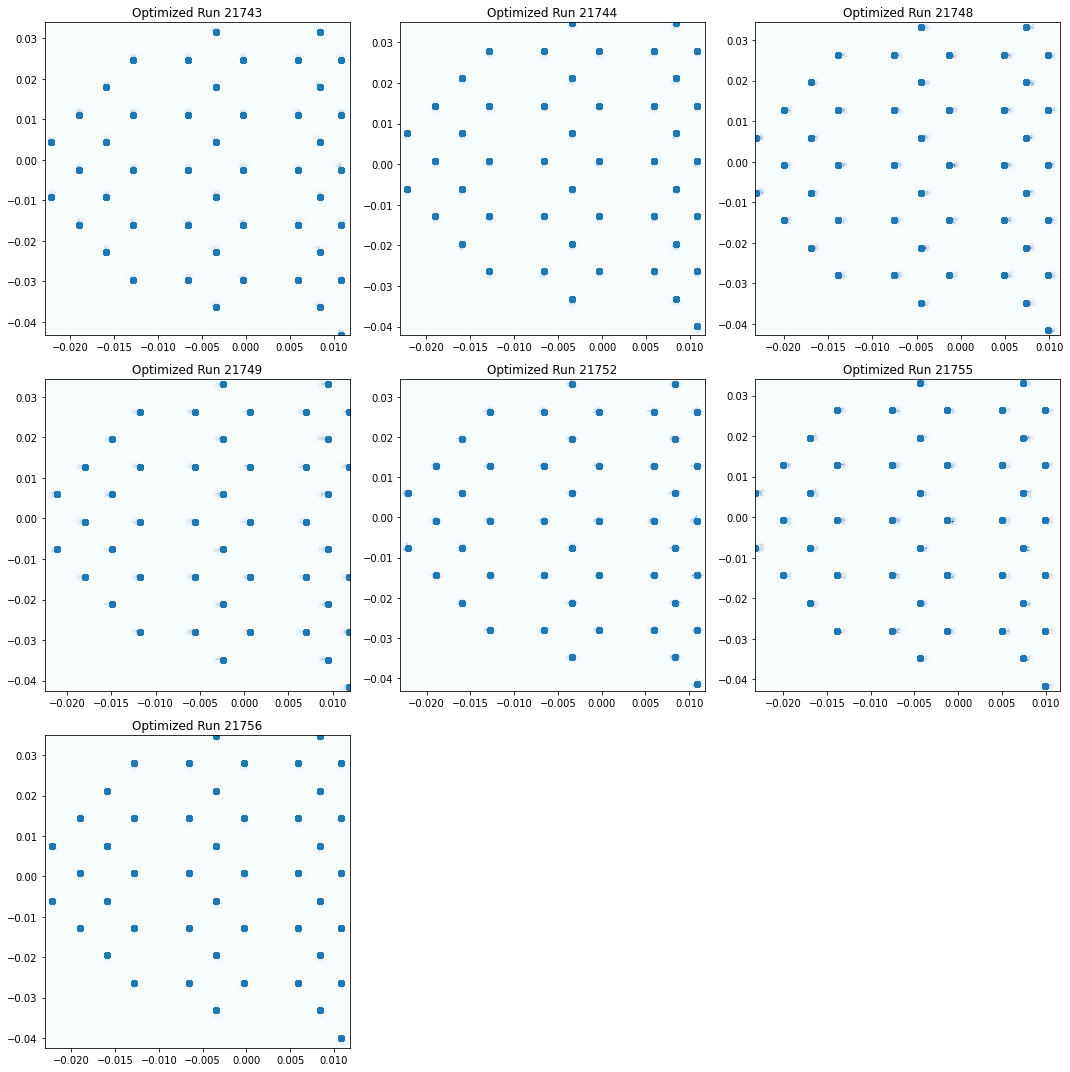

In [58]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=[15,15])
gs = gridspec.GridSpec(nrows=3, ncols=3, height_ratios=[1, 1, 1])

plotArr  = {gs[0,0]:21743, gs[0,1]:21744,gs[0,2]:21748,gs[1,0]:21749,gs[1,1]:21752,gs[1,2]:21755,gs[2,0]:21756}
subplot ={}


for key, runID in plotArr.items():
    currentdata = fulldata[fulldata.runID.eq(runID)]
    subplot[runID] =fig.add_subplot(key)
    subplot[runID].hist2d(currentdata['predicted_phi'],currentdata['predicted_theta'],bins=300,cmap=plt.cm.BuPu)
    subplot[runID].scatter(currentdata['targCalPh'],currentdata['targCalTh'])
    subplot[runID].set_title("Optimized Run {}".format(runID))

plt.tight_layout()
plt.show()

## Save  the model

In [70]:
runList = dataInitial['runID'].unique()

for currentrun in runList:
    currentdata = fulldata[fulldata.runID.eq(currentrun)]
    currentdata.to_csv("../result/trainRes_run_{}.csv".format(currentrun),index=False)